In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os


In [2]:
DATA_DIR = '/kaggle/input/bangla-ner/data/'

In [3]:
train_data = pd.read_csv(DATA_DIR+'train.txt', sep=" ", header=None, dtype='str', skip_blank_lines=False)
train_data.head(20)

,0,1,2,3
0,তার,_,_,O
1,মৃত্যুর,_,_,O
2,দশ,_,_,O
3,দিন,_,_,O
4,"পর,",_,_,O
5,১১৫,_,_,O
6,কৃষ্ণাঙ্গ,_,_,O
7,উচ্চ,_,_,O
8,বিদ্যালয়ের,_,_,O
9,শিক্ষার্থীরা,_,_,O


* Note: we will use NaNs to represent end of sequence, we need so build sequential models later

# Exploratory analysis
Intentions
- find out different entities found in the training set
- find out what kind of tags exist in the training set
- something to do about the entities that exist in training but not in the test/valid set 

In [4]:
train_data.columns = ['entity', 'space1','space2', 'tag']

In [5]:
train_data.drop(['space1', 'space2'], axis=1, inplace=True)

In [6]:
train_data.head()

,entity,tag
0,তার,O
1,মৃত্যুর,O
2,দশ,O
3,দিন,O
4,"পর,",O


In [7]:
train_data.shape

(184086, 2)

In [8]:
train_data['entity'].unique()

array(['তার', 'মৃত্যুর', 'দশ', ..., 'নভেম্বরের', 'আসবেন', 'দরগৌদ'],
      dtype=object)

In [9]:
len(train_data['entity'].unique())

30798

In [10]:
train_data['tag'].unique()

array(['O', 'B-LOC', nan, 'B-GRP', 'I-GRP', 'B-PROD', 'B-CW', 'I-CW',
       'B-CORP', 'B-PER', 'I-PER', 'I-CORP', 'I-PROD', 'I-LOC'],
      dtype=object)

In [11]:
len(train_data['tag'].unique())

14

## Check how many sequences are there

In [12]:
train_data.isnull().sum().sort_values(ascending=False)

entity    13592
tag       13592
dtype: int64

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184086 entries, 0 to 184085
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   entity  170494 non-null  object
 1   tag     170494 non-null  object
dtypes: object(2)
memory usage: 2.8+ MB


# Convert data type for ease of pre-processing

In [14]:
train_data['entity'] = train_data['entity'].astype(str)
train_data['tag'] = train_data['tag'].astype(str)
        

# Check for punctuations and other not useful characters

In [15]:
non_alpha = set('''````£|¢|Ñ+-*/=EROero৳•।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰''')
#train_data['entity'].values

In [16]:
found_nonalphas = set()
for ent in train_data['entity'].values:
    if ent in non_alpha:
        found_nonalphas.add(ent)
        

In [17]:
found_nonalphas

{'!',
 '#',
 '$',
 '%',
 '&',
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '?',
 '@',
 ']',
 '|',
 '£',
 '।',
 '’',
 '”'}

Since lots of punctuations and other chars are found we need to clean the entites to get rid of them
doing so would increase our chosen method's learning abilities without distracting the model on useless items 

In [18]:
def clean_entity(text):
    found_nonalphas = set()
    if text:
        ans = ''
        for ent in text:
            if ent not in non_alpha:
                ans += ent
        return ans
    else:
        return np.nan

In [19]:
train_data['entity'] = train_data['entity'].apply(clean_entity)

In [20]:
train_data.head(10)

,entity,tag
0,তার,O
1,মৃত্যুর,O
2,দশ,O
3,দিন,O
4,পর,O
5,১১৫,O
6,কৃষ্ণাঙ্গ,O
7,উচ্চ,O
8,বিদ্যালয়ের,O
9,শিক্ষার্থীরা,O


# Check the distribution of tags
- we determine which tags appear the most overall and in individual sequences
- identify the underrepresented tags

In [21]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

let's check first few sequences

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='tag', ylabel='count'>

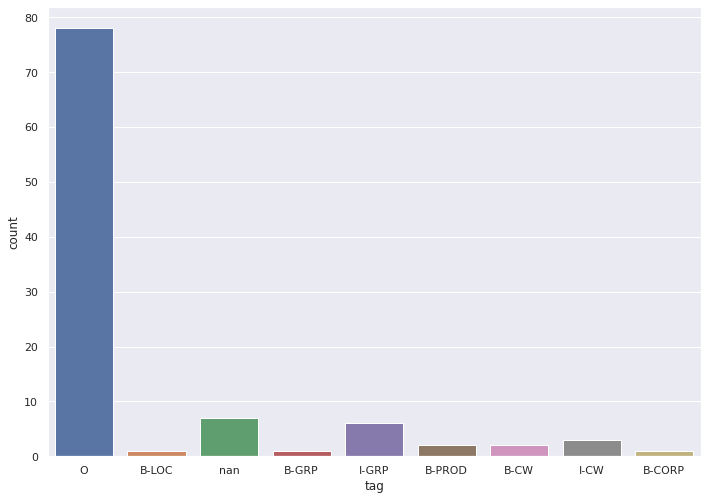

In [22]:
sns.countplot(train_data.loc[:100,'tag'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='tag', ylabel='count'>

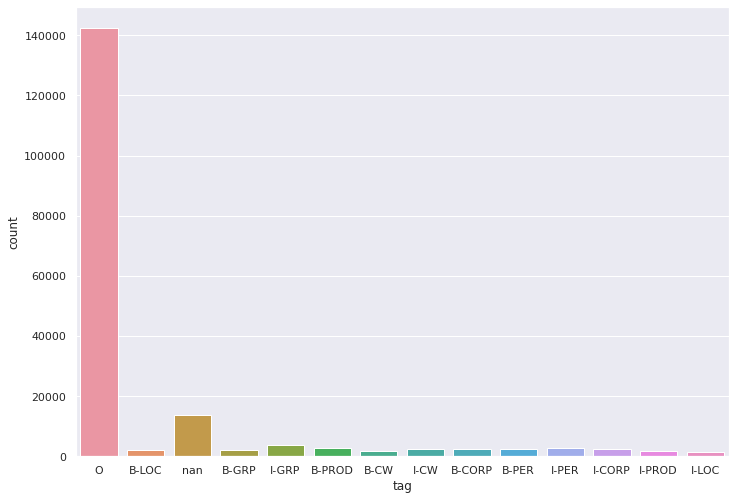

In [23]:

sns.countplot(train_data['tag'])

Ignoring nans for according to our assumption, the distribution of different desired entities remain equal and dominated by `unidentified` entities which is normal since not every specific entity is a NER.

In [24]:
pos_dataset = pd.read_csv('/kaggle/input/bangla-parts-of-speechpos-tag/postag.txt', sep=" ", header=None, dtype='str')
pos_dataset.head()

,0,1
0,অ,adjective
1,অআ,noun
2,অই,noun
3,অইছে,adjective
4,অইছন,adjective


In [25]:
pos_dict = dict(zip(pos_dataset[0], pos_dataset[1]))

In [26]:
def add_pos(ent):
    return pos_dict.get(ent, 'UNK')

# Add the pos tags if available, else put UNK

In [27]:
train_data['pos'] = train_data['entity'].apply(add_pos)

In [28]:
train_data.head()

,entity,tag,pos
0,তার,O,pronoun
1,মৃত্যুর,O,UNK
2,দশ,O,adverb
3,দিন,O,verb
4,পর,O,adjective


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


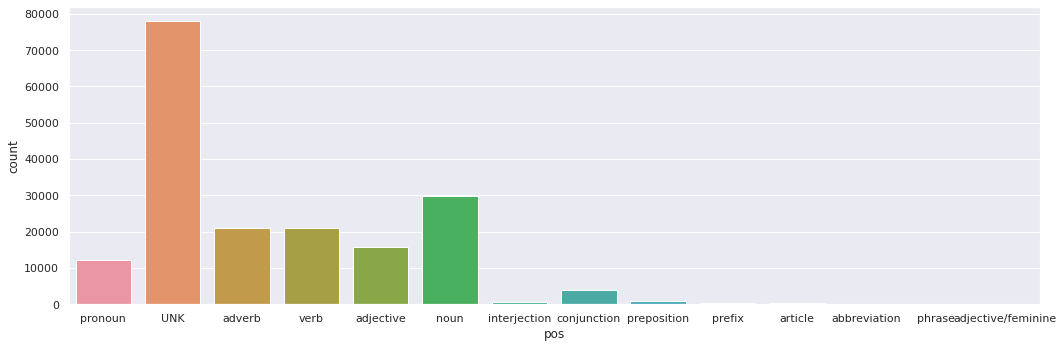

In [29]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(train_data['pos'])
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [30]:
valid_data = pd.read_csv(DATA_DIR+'dev.txt', sep=" ", header=None, dtype='str', skip_blank_lines=False)
valid_data.columns = ['entity', 'space1','space2', 'tag']
valid_data.drop(['space1', 'space2'], axis=1, inplace=True)
valid_data['entity'] = valid_data['entity'].astype(str)
valid_data['tag'] = valid_data['tag'].astype(str)
valid_data['entity'] = valid_data['entity'].apply(clean_entity)
valid_data['pos'] = valid_data['entity'].apply(add_pos)

In [31]:
train_data.to_csv('cleaned_train.csv',header=True, index=False)
valid_data.to_csv('cleaned_valid.csv', header=True, index=False)